<a href="https://colab.research.google.com/github/YannEhouman/Produire_une_etude_de_marche/blob/main/Ehouman_Yann_1_notebook_102022_version_ant%C3%A9rieure_au_21_septembre_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

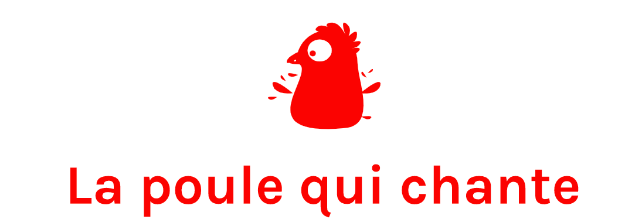

# <font color="red">**I. PREPARATION DES DONNEES**</font>

## <font color="red">**Les librairies**</font>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster, metrics
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from matplotlib.collections import LineCollection
#from functions import *
from sklearn.metrics import silhouette_score
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")
from yellowbrick.cluster import SilhouetteVisualizer

## <font color="red">**Les fonctions graphiques**</font>

Chargeons les fonctions graphiques qui nous seront utile pour la suite du projet. A savoir "sns.set()" et " "display_circles"

In [ ]:
sns.set()

In [ ]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
      for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(8,8))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

## <font color="red">**Le chargement des données**</font>

Nous allons maintenant charger les données. Importons notre fichier "DisponibiliteAlimentaire_2017.csv".

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Cours/OPEN CLASSROOM/P9_Ehouman_Yann/DisponibiliteAlimentaire_2017.csv')
data.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.0,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.0,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.0,S,Données standardisées
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5911,Exportations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,0.0,S,Données standardisées
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2511,Blé et produits,2017,2017,Milliers de tonnes,6701.0,S,Données standardisées


In [ ]:
data.shape

(176600, 14)

In [ ]:
# Afficher uniquement les colonnes dont nous avons besoin
data_nv=data.loc[:,['Zone','Élément','Produit','Valeur']]
data_nv.head()

,Zone,Élément,Produit,Valeur
0,Afghanistan,Production,Blé et produits,4281.0
1,Afghanistan,Importations - Quantité,Blé et produits,2302.0
2,Afghanistan,Variation de stock,Blé et produits,-119.0
3,Afghanistan,Exportations - Quantité,Blé et produits,0.0
4,Afghanistan,Disponibilité intérieure,Blé et produits,6701.0


In [ ]:
# aucune valeur manquante
data_nv.isnull().sum()

Zone       0
Élément    0
Produit    0
Valeur     0
dtype: int64

In [ ]:
# Conserver uniquement les données concernant le produit 'Viande de Volailles'
data_volaille = data_nv.loc[data_nv['Produit']==  'Viande de Volailles']
data_volaille.head()

,Zone,Élément,Produit,Valeur
651,Afghanistan,Production,Viande de Volailles,28.0
652,Afghanistan,Importations - Quantité,Viande de Volailles,29.0
653,Afghanistan,Variation de stock,Viande de Volailles,0.0
654,Afghanistan,Disponibilité intérieure,Viande de Volailles,57.0
655,Afghanistan,Pertes,Viande de Volailles,2.0


In [ ]:
# Vérifier les types de valeurs
data_volaille.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2061 entries, 651 to 176400
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Zone     2061 non-null   object 
 1   Élément  2061 non-null   object 
 2   Produit  2061 non-null   object 
 3   Valeur   2061 non-null   float64
dtypes: float64(1), object(3)
memory usage: 80.5+ KB


In [ ]:
# Faire un pivot de la colonne Élément et vérifier le nombre de valeurs nulles par colonne
v_v=data_volaille.pivot_table(index='Zone', columns='Élément', values = 'Valeur')
v_v.isnull().sum()

Élément
Alimentation pour touristes                                       94
Aliments pour animaux                                            171
Autres utilisations (non alimentaire)                            138
Disponibilité alimentaire (Kcal/personne/jour)                     0
Disponibilité alimentaire en quantité (kg/personne/an)             0
Disponibilité de matière grasse en quantité (g/personne/jour)      0
Disponibilité de protéines en quantité (g/personne/jour)           0
Disponibilité intérieure                                           2
Exportations - Quantité                                           37
Importations - Quantité                                            2
Nourriture                                                         2
Pertes                                                           105
Production                                                         4
Résidus                                                            8
Semences                  

In [ ]:
# Les variables que nous utiliserons pour nos analyses sont les disponibilités, l'exportation, l'importation, et la production
# Remplacer les valeurs nulles des colonnes par leurs moyennes
v_v=data_volaille.pivot_table(index='Zone', columns='Élément', values = 'Valeur').fillna(v_v.mean())
v_v.head()

Élément,Alimentation pour touristes,Aliments pour animaux,Autres utilisations (non alimentaire),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Résidus,Semences,Traitement,Variation de stock
Zone,,,,,,,,,,,,,,,,,
Afghanistan,0.217949,0.0,44.117647,5.0,1.53,0.33,0.54,57.0,132.185185,29.0,55.0,2.00000,28.0,0.0,0.0,26.282609,0.0
Afrique du Sud,0.000000,0.0,44.117647,143.0,35.69,9.25,14.11,2118.0,63.000000,514.0,2035.0,83.00000,1667.0,0.0,0.0,26.282609,0.0
Albanie,0.217949,0.0,44.117647,85.0,16.36,6.45,6.26,47.0,0.000000,38.0,47.0,43.58209,13.0,0.0,0.0,26.282609,4.0
Algérie,0.000000,0.0,44.117647,22.0,6.38,1.50,1.97,277.0,0.000000,2.0,264.0,13.00000,275.0,0.0,0.0,26.282609,0.0
Allemagne,0.217949,0.0,44.117647,71.0,19.47,4.16,7.96,1739.0,646.000000,842.0,1609.0,43.58209,1514.0,-38.0,0.0,167.000000,-29.0


### <font color="red">**La variable Taux de Dépendance à l'Importation(TDI)**</font>


**Définitions :**

*   Taux de dépendance aux importations (TDI) = (Importation ÷ Disponibilité intérieure) x 100

Le TDI est une variable intéréssante. Elle nous permet d'avoir deux indicateurs en un. 

In [ ]:
# calcul de la nouvelle variable le TDI
v_v['TDI (%)']=(v_v['Importations - Quantité']/v_v['Disponibilité intérieure'])*100
v_v.head()

Élément,Alimentation pour touristes,Aliments pour animaux,Autres utilisations (non alimentaire),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Résidus,Semences,Traitement,Variation de stock,TDI (%)
Zone,,,,,,,,,,,,,,,,,,
Afghanistan,0.217949,0.0,44.117647,5.0,1.53,0.33,0.54,57.0,132.185185,29.0,55.0,2.00000,28.0,0.0,0.0,26.282609,0.0,50.877193
Afrique du Sud,0.000000,0.0,44.117647,143.0,35.69,9.25,14.11,2118.0,63.000000,514.0,2035.0,83.00000,1667.0,0.0,0.0,26.282609,0.0,24.268178
Albanie,0.217949,0.0,44.117647,85.0,16.36,6.45,6.26,47.0,0.000000,38.0,47.0,43.58209,13.0,0.0,0.0,26.282609,4.0,80.851064
Algérie,0.000000,0.0,44.117647,22.0,6.38,1.50,1.97,277.0,0.000000,2.0,264.0,13.00000,275.0,0.0,0.0,26.282609,0.0,0.722022
Allemagne,0.217949,0.0,44.117647,71.0,19.47,4.16,7.96,1739.0,646.000000,842.0,1609.0,43.58209,1514.0,-38.0,0.0,167.000000,-29.0,48.418631


In [ ]:
# dataset avec les colonnes à utiliser pour les jointures et en suite notre analyse
dataset= v_v.loc[:,['Disponibilité alimentaire en quantité (kg/personne/an)','TDI (%)']]
dataset.head()

Élément,Disponibilité alimentaire en quantité (kg/personne/an),TDI (%)
Zone,,
Afghanistan,1.53,50.877193
Afrique du Sud,35.69,24.268178
Albanie,16.36,80.851064
Algérie,6.38,0.722022
Allemagne,19.47,48.418631


### <font color="red">**La variable de la croissance de la population**</font> 

In [ ]:
population = pd.read_csv('/content/drive/MyDrive/Cours/OPEN CLASSROOM/P9_Ehouman_Yann/Population_2000_2018.csv')
population.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,NaN


Regardons la forme du DataFrame :

In [ ]:
population.shape

(4411, 15)

**CALCULER LE TAUX DE CROISSANCE DEMOGRAPHIQUE SUR 18 ANS**

Cette nouvelle variable qui reflète la dynamique démographique sur la période 2000-2018

In [ ]:
# Calculer une nouvelle variable pour notre analyse : la croissance démographique en % entre 2000 et 2018

population_nv=population.pivot_table(index = 'Zone', columns = 'Année', values = 'Valeur')
population_nv['Croissance démographique (%)']=(population_nv[2018]-population_nv[2000]) /(population_nv[2000])
population_nv.head()

Année,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,Croissance démographique (%)
Zone,,,,,,,,,,,,,,,,,,,,
Afghanistan,20779.953,21606.988,22600.770,23680.871,24726.684,25654.277,26433.049,27100.536,27722.276,28394.813,29185.507,30117.413,31161.376,32269.589,33370.794,34413.603,35383.032,36296.113,37171.921,0.788836
Afrique du Sud,44967.708,45571.274,46150.913,46719.196,47291.610,47880.601,48489.459,49119.759,49779.471,50477.011,51216.964,52003.755,52832.658,53687.121,54544.186,55386.367,56207.646,57009.756,57792.518,0.285200
Albanie,3129.243,3129.704,3126.187,3118.023,3104.892,3086.810,3063.021,3033.998,3002.678,2973.048,2948.023,2928.592,2914.096,2903.790,2896.305,2890.513,2886.438,2884.169,2882.740,-0.078774
Algérie,31042.235,31451.514,31855.109,32264.157,32692.163,33149.724,33641.002,34166.972,34730.608,35333.881,35977.455,36661.445,37383.895,38140.133,38923.692,39728.025,40551.392,41389.189,42228.408,0.360353
Allemagne,81400.882,81453.885,81535.122,81614.380,81646.474,81602.741,81472.226,81277.830,81065.752,80899.961,80827.002,80855.632,80972.628,81174.367,81450.378,81787.411,82193.768,82658.409,83124.418,0.021173


In [ ]:
# Conserver uniquement la colonne croissance démographique pour notre analyse
population_1=population_nv.loc[:,['Croissance démographique (%)']]
population_1.head()

Année,Croissance démographique (%)
Zone,
Afghanistan,0.788836
Afrique du Sud,0.285200
Albanie,-0.078774
Algérie,0.360353
Allemagne,0.021173


In [ ]:
population_1.shape

(238, 1)

### <font color="red">**La variable PIB/Habitant**</font>

In [ ]:
pib = pd.read_csv('/content/drive/MyDrive/Cours/OPEN CLASSROOM/P9_Ehouman_Yann/FAOSTAT_data_fr_9-14-2022.csv')

# Afficher uniquement les colonnes dont nous avons besoin
pib_nv=pib.loc[:,['Zone','Valeur']]

pib2 = pib_nv.rename(columns ={'Valeur':'PIB/habitant'})
pib2.head()

,Zone,PIB/habitant
0,Afghanistan,508.453722
1,Afrique du Sud,5094.384038
2,Albanie,5180.914198
3,Algérie,3367.963003
4,Allemagne,45908.724713


### <font color="red">**La variable de la stabilité politique** </font>

In [ ]:
stab = pd.read_csv('/content/drive/MyDrive/Cours/OPEN CLASSROOM/P9_Ehouman_Yann/FAOSTAT_data_fr_9-14-2022 (1).csv')

# Afficher uniquement les colonnes dont nous avons besoin
stab_nv=stab.loc[:,['Zone','Valeur']]

stab2 = stab_nv.rename(columns ={'Valeur':'Stabilité Politique'})
stab2.head()

,Zone,Stabilité Politique
0,Afghanistan,-2.73
1,Afrique du Sud,-0.24
2,Albanie,0.08
3,Algérie,-0.86
4,Allemagne,0.67


## <font color="red">**Les jointures**</font>

In [ ]:
# Effectuer la jointure entre le dataset résulant de population avec celui des disponibilités alimentaires
jointure=dataset.merge(population_1,on='Zone',how='inner')

# Effectuer la deuxieme jointure entre la premiere jointure avec celui du fichier pib
jointure2=jointure.merge(pib2,on='Zone',how='inner')

# Effectuer la troisieme jointure entre la jointure précédente avec celui du fichier de la stabilité politique
jointure3=jointure2.merge(stab2,on='Zone',how='inner')

jointure3.head()


,Zone,Disponibilité alimentaire en quantité (kg/personne/an),TDI (%),Croissance démographique (%),PIB/habitant,Stabilité Politique
0,Afghanistan,1.53,50.877193,0.788836,508.453722,-2.73
1,Afrique du Sud,35.69,24.268178,0.285200,5094.384038,-0.24
2,Albanie,16.36,80.851064,-0.078774,5180.914198,0.08
3,Algérie,6.38,0.722022,0.360353,3367.963003,-0.86
4,Allemagne,19.47,48.418631,0.021173,45908.724713,0.67


In [ ]:
#Y-a-t-il des valeurs nulles ? 
jointure3.isnull().sum()

Zone                                                      0
Disponibilité alimentaire en quantité (kg/personne/an)    0
TDI (%)                                                   0
Croissance démographique (%)                              3
PIB/habitant                                              0
Stabilité Politique                                       0
dtype: int64

In [ ]:
#Remplacement des valeurs nulles de la colonne 'Croissance démo' par la moyenne
jointure3['Croissance démographique (%)'].fillna(value=jointure3['Croissance démographique (%)'].mean(), inplace=True)

#Indexation de la colonne 'Zone'
jointure3.set_index('Zone',inplace = True)

# <font color="red">**II. ANALYSE DES DONNEES**</font>

## <font color="red">**La classification ascendante hiérachique (cah)**</font>

In [ ]:
# Selectionner les valeurs à utiliser pour notre analyse
X = jointure3.values
#Centrage / réduction des données pour que nos données puissent prendre la même importance
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
#Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward
Z = linkage(X_scaled, method = 'ward', metric='euclidean')

## <font color="red">**Le dendrogramme**</font>

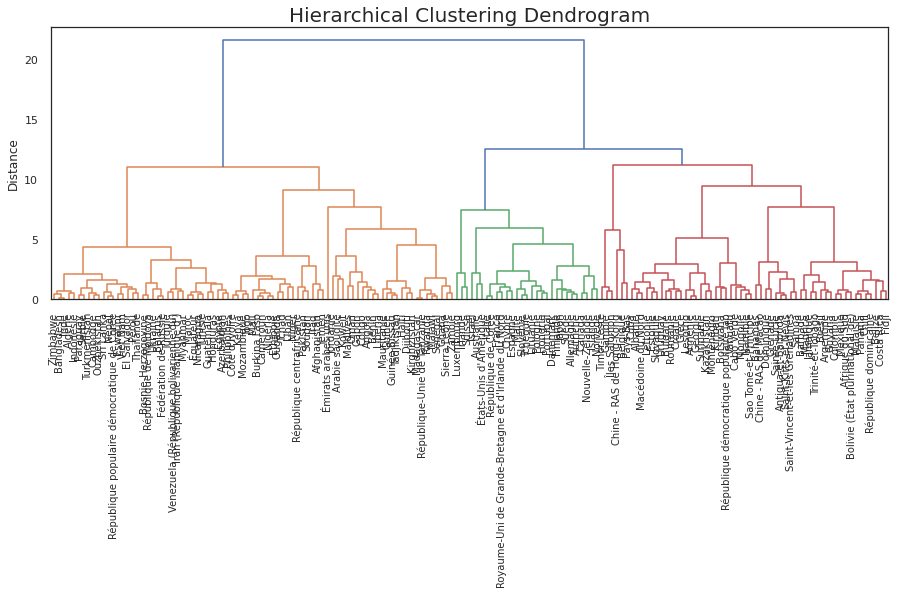

In [ ]:
#Clustering hiérarchique: 
#Affichage d'un premier dendrogramme global
fig =plt.figure(figsize=(15,5))
sns.set_style('white')
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.ylabel('Distance')
dendrogram(Z, labels = jointure3.index, leaf_font_size=10, color_threshold=12, orientation='top')
plt.show()

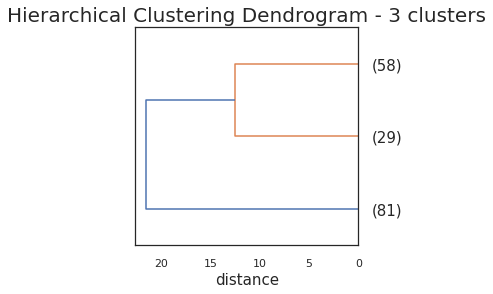

In [ ]:
#Découpage du dendrogramme en 3 groupes pour avoir une première idée du partitionnement
fig = plt.figure(figsize=(4,4))
plt.title('Hierarchical Clustering Dendrogram - 3 clusters', fontsize=20)
plt.xlabel('distance', fontsize=15)
dendrogram(Z, labels = jointure3.index, p=3, truncate_mode='lastp', leaf_font_size=15, orientation='left')
plt.show()

## <font color="red">**La methode K-Means**</font>

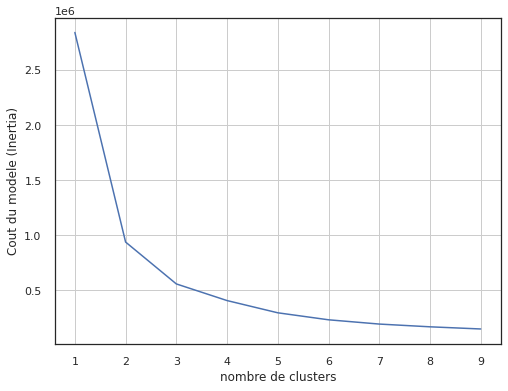

In [ ]:
inertia = []
k_range=range(1,10)
for k in k_range:
    model=KMeans(n_clusters=k).fit(Z)
    inertia.append(model.inertia_)
    
fig = plt.figure(figsize=(8,6))
plt.plot(k_range,inertia )
plt.xlabel('nombre de clusters')
plt.ylabel('Cout du modele (Inertia)')
plt.grid()
plt.show()

Plus il y a de clusters, plus le nombre d'individus par cluster diminue, et plus les clusters sont resserrés. Donc, bien entendu, l’inertie intraclasse diminue forcément quand K augmente !

Pour déterminer le nombre de clusters à étudier, on s'intéresse au graphique qui trace l'inertie intraclasse en fonction du nombre de clusters. On cherche plus particulièrement une "cassure" dans la courbe. Cette "cassure" nous indique à partir de quel nombre de clusters nous "allons trop loin". Ici **3 clusters** !

**AFFICHAGE DES CLUSTERS ET CENTROÏDES**

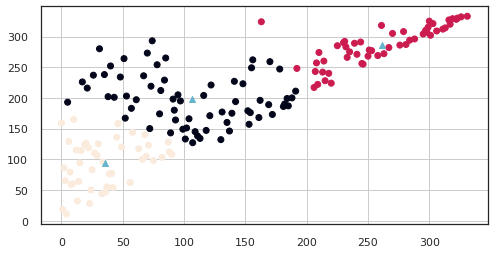

Inertie totale : 557616.2584016576


In [ ]:
# Affichage du nuage de points (individus) en cluster avec les centoîdes
fig = plt.figure(figsize=(8,4))
model = KMeans(n_clusters=3)
model.fit(Z)
model.predict(Z)
plt.scatter(Z[:,0], Z[:,1],c=model.predict(Z))
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], marker='^',c='c')
plt.grid()
plt.show()
print('Inertie totale :',model.inertia_)

## <font color="red">**L'analyse des 3 groupes**</font>

Découpage en classes – Matérialisation des groupes

In [ ]:
#Identification des 3 groupes obtenus
groupes_cah = fcluster(Z, 3, criterion='maxclust')
#index triés des groupes
idg = np.argsort(groupes_cah)
#Affichage des pays selon leurs groupes
df = pd.DataFrame(jointure3.index[idg], groupes_cah[idg]).reset_index()
df2 = df.rename(columns={'index':'Groupe'})
df2.head()

,Groupe,Zone
0,1,Afghanistan
1,1,Ouzbékistan
2,1,Ouganda
3,1,Oman
4,1,Népal


In [ ]:
#Intégration des références des groupes dans notre échantillon de départ représenté par le dataframe "dataset"
#Jointure interne nécessaire pour parvenir à agréger nos données
df3 = pd.merge(jointure3, df2, on='Zone')
df3.set_index('Zone', inplace=True)
df3.head()

,Disponibilité alimentaire en quantité (kg/personne/an),TDI (%),Croissance démographique (%),PIB/habitant,Stabilité Politique,Groupe
Zone,,,,,,
Afghanistan,1.53,50.877193,0.788836,508.453722,-2.73,1
Afrique du Sud,35.69,24.268178,0.285200,5094.384038,-0.24,3
Albanie,16.36,80.851064,-0.078774,5180.914198,0.08,3
Algérie,6.38,0.722022,0.360353,3367.963003,-0.86,1
Allemagne,19.47,48.418631,0.021173,45908.724713,0.67,2



## <font color="red">**Boxplot : Distribution des variables par groupe**</font>

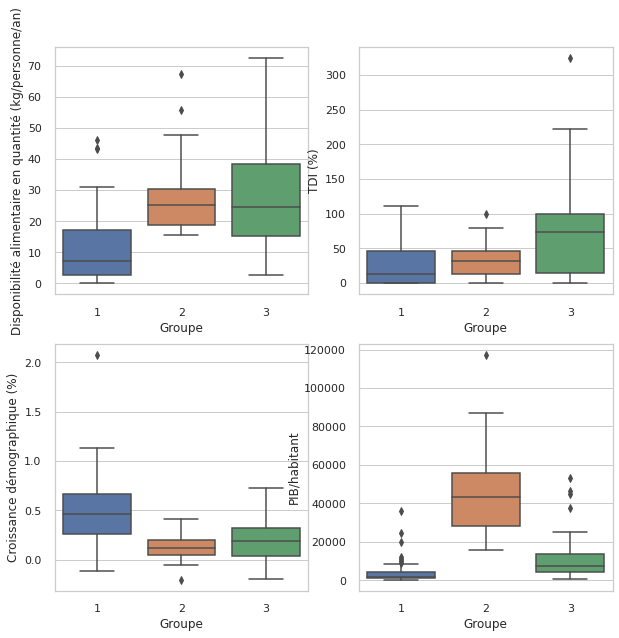

In [ ]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(10, 10))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=df3, x='Groupe', y='Disponibilité alimentaire en quantité (kg/personne/an)')
plt.subplot(222)
sns.boxplot(data=df3, x='Groupe', y='TDI (%)')
plt.subplot(223)
sns.boxplot(data=df3, x='Groupe', y='Croissance démographique (%)')
plt.subplot(224)
sns.boxplot(data=df3, x='Groupe', y='PIB/habitant')
plt.savefig('Distribution des variables par groupe.jpg')

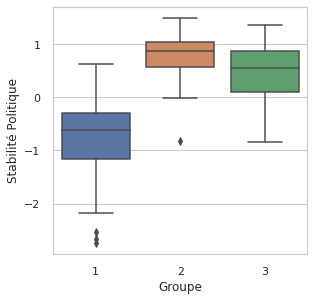

In [ ]:
plt.figure(figsize=(10, 10))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=df3, x='Groupe', y='Stabilité Politique')
plt.savefig('Distribution des variables par groupe_suite.jpg')

## <font color="red">**Moyenne des 3 classes**</font> 

In [ ]:
cluster_1 = df3.loc[df3['Groupe']==1]
cluster_1.head()

,Disponibilité alimentaire en quantité (kg/personne/an),TDI (%),Croissance démographique (%),PIB/habitant,Stabilité Politique,Groupe
Zone,,,,,,
Afghanistan,1.53,50.877193,0.788836,508.453722,-2.73,1
Algérie,6.38,0.722022,0.360353,3367.963003,-0.86,1
Angola,10.56,86.833856,0.879164,1895.770703,-0.52,1
Arabie saoudite,43.36,50.313589,0.631001,20110.315319,-0.66,1
Azerbaïdjan,13.11,20.930233,0.224899,4202.232239,-0.73,1


In [ ]:
cluster_2 = df3.loc[df3['Groupe']==2]
cluster_2.head()

,Disponibilité alimentaire en quantité (kg/personne/an),TDI (%),Croissance démographique (%),PIB/habitant,Stabilité Politique,Groupe
Zone,,,,,,
Allemagne,19.47,48.418631,0.021173,45908.724713,0.67,2
Australie,47.65,1.366354,0.311020,55822.712845,0.85,2
Autriche,18.20,63.583815,0.101882,48105.631983,0.85,2
Canada,39.02,12.700628,0.212047,43559.710092,1.11,2
Chypre,25.08,36.842105,0.260763,28133.071159,0.29,2


In [ ]:
cluster_3 = df3.loc[df3['Groupe']==3]
cluster_3.head()

,Disponibilité alimentaire en quantité (kg/personne/an),TDI (%),Croissance démographique (%),PIB/habitant,Stabilité Politique,Groupe
Zone,,,,,,
Afrique du Sud,35.69,24.268178,0.285200,5094.384038,-0.24,3
Albanie,16.36,80.851064,-0.078774,5180.914198,0.08,3
Antigua-et-Barbuda,54.10,100.000000,0.266654,13993.320179,0.93,3
Argentine,42.24,0.407747,0.203152,8475.729582,0.04,3
Arménie,16.06,74.468085,-0.038391,4266.005479,-0.57,3


In [ ]:
#afficher les moyennes des variables de chaque groupe
groupe=(1,2,3)
for n in groupe:
    affi=df3.loc[df3['Groupe']==n].mean()
    print(affi)

Disponibilité alimentaire en quantité (kg/personne/an)      11.285062
TDI (%)                                                     29.043782
Croissance démographique (%)                                 0.474956
PIB/habitant                                              3916.604317
Stabilité Politique                                         -0.758765
Groupe                                                       1.000000
dtype: float64
Disponibilité alimentaire en quantité (kg/personne/an)       27.851034
TDI (%)                                                      32.582735
Croissance démographique (%)                                  0.126522
PIB/habitant                                              45795.078168
Stabilité Politique                                           0.775172
Groupe                                                        2.000000
dtype: float64
Disponibilité alimentaire en quantité (kg/personne/an)       27.988276
TDI (%)                                              

In [ ]:
df4 = df3.reset_index()
test = df4.groupby(['Groupe']).mean()
test.head()

,Disponibilité alimentaire en quantité (kg/personne/an),TDI (%),Croissance démographique (%),PIB/habitant,Stabilité Politique
Groupe,,,,,
1,11.285062,29.043782,0.474956,3916.604317,-0.758765
2,27.851034,32.582735,0.126522,45795.078168,0.775172
3,27.988276,74.317708,0.188594,11096.491824,0.431724


## <font color="red">**La heatmap**</font>

<Figure size 504x504 with 0 Axes>

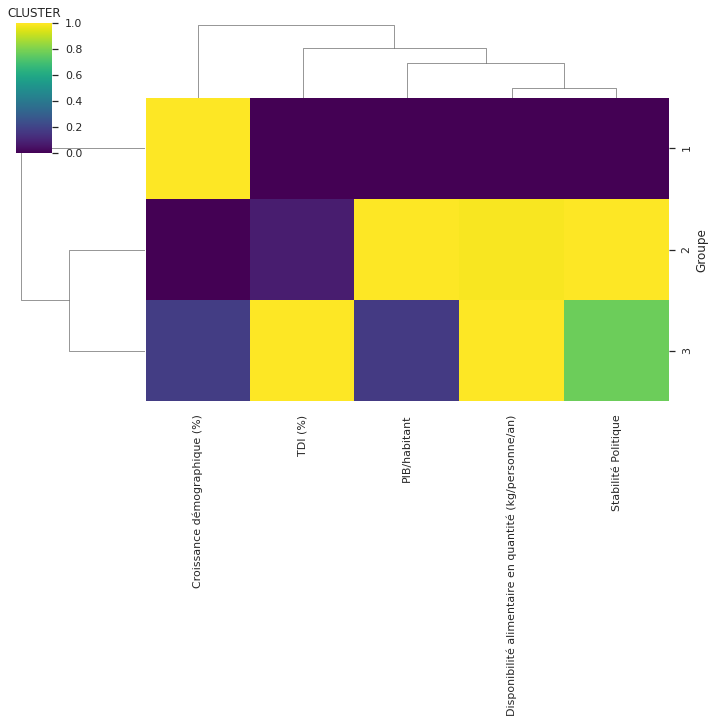

In [ ]:
#heatmap avec les croisements entre les clusters de pays et les différentes variables
plt.figure(figsize=(7, 7))
sns.clustermap(test, cmap = 'viridis',method = 'ward',metric = 'euclidean',standard_scale =1,figsize = (10, 10))
#sns.heatmap(df.corr(), annot=True, cmap='Greens')
plt.title('CLUSTER')
plt.savefig('Heatmap Cluster.jpg')

## <font color="red">**L'analyse en composantes principales**</font>

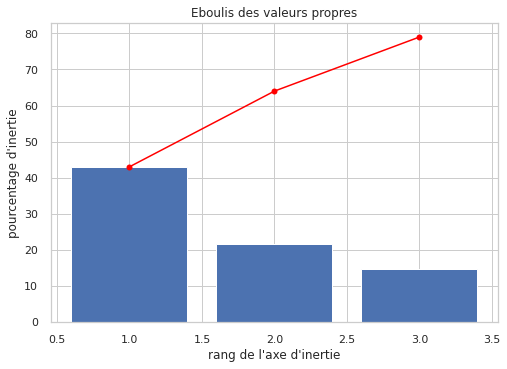

In [ ]:
# choix du nombre de composantes à calculer
n_components = 3
pca = decomposition.PCA(n_components=n_components)
pca.fit(X_scaled)
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
x_list = range(1, n_components+1)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

## <font color="red">**Les cercles de correlations**</font>

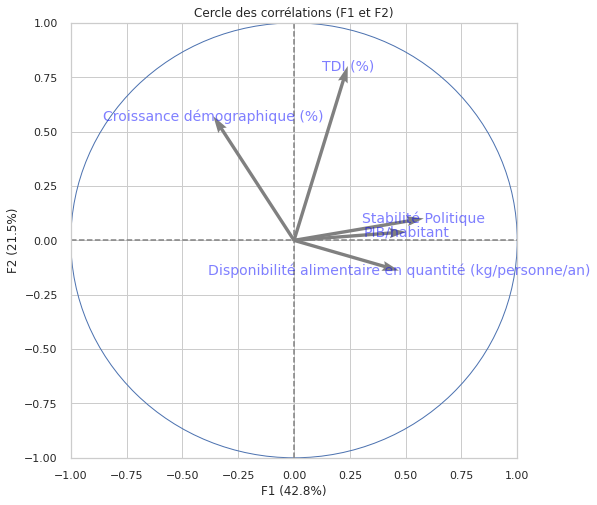

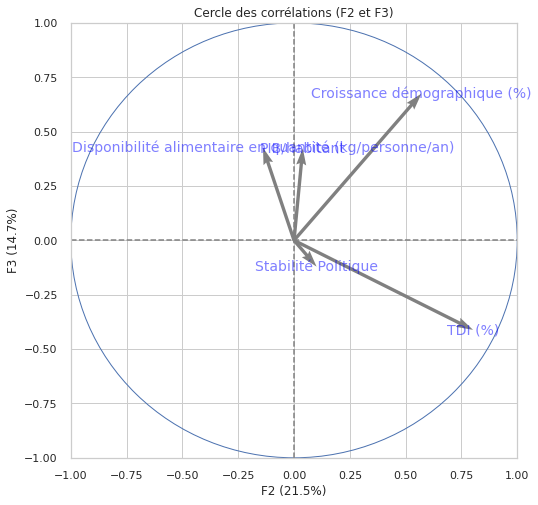

In [ ]:
# selection des colonnes à prendre en compte dans l'ACP
features = jointure3.columns
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_components, pca, [(0,1),(1,2)], labels = np.array(features) )
plt.show()

In [ ]:
# création de la matrice de corrélation
t=pca.components_[:]
df_corr_comp = pd.DataFrame(t,index = ['F1', 'F2', 'F3'],columns=jointure3.columns)
df_corr_comp.head()

,Disponibilité alimentaire en quantité (kg/personne/an),TDI (%),Croissance démographique (%),PIB/habitant,Stabilité Politique
F1,0.469949,0.240720,-0.361308,0.502631,0.581394
F2,-0.139124,0.802045,0.570626,0.039239,0.101072
F3,0.426208,-0.411532,0.674641,0.423364,-0.120872


**OBSERVATIONS**


F1 : Disponibiltés alimentaires (0,46), PIB/hab (0.50) & stabilité politique (0,58) sont correlées. On peut dire que l'axe F1 représente la prosperité économique




---



F2 : Le TDI est très correlé (0.80) comme la croissance économique (0,57). F2 est l'axe des pays importateurs en croissance démographique, pays en voix de developpement


---



F3 : La croissance démographique est élévé (0,67)


---



In [ ]:
# composantes F1
# "Disponibilité alimentaire en quantité (kg/personne/an)",	"TDI (%)",	"Croissance démographique (%)",	"PIB/habitant" , "revenus", "Stabilité Politique"
f1 = pca.components_[0]

# composantes F2
# "Disponibilité alimentaire en quantité (kg/personne/an)",	"TDI (%)",	"Croissance démographique (%)",	"PIB/habitant" , "revenus", "Stabilité Politique"
f2 = pca.components_[1]

# composantes F3
# "Disponibilité alimentaire en quantité (kg/personne/an)",	"TDI (%)",	"Croissance démographique (%)",	"PIB/habitant" , "revenus", "Stabilité Politique"
f3 = pca.components_[2]


In [ ]:
# Projection des individus
X_projected = pca.transform(X_scaled)

# Obtention F1 & F2 & F3
data_fn = pd.DataFrame(X_projected, index=df3.index,columns=["F"+str(i+1) for i in range(3)])
data_fn = data_fn.reset_index()
#data_fn.info()
#data_fn = data_fn[["country","F1", "F2"]]

# merge data & data_1
data_bon = pd.merge(df3,data_fn, how="inner", on="Zone")

In [ ]:
#Récupération de clusters
cluster_cent = pd.DataFrame(data_bon.groupby(["Groupe" ]).mean())
cluster_cent = cluster_cent.reset_index()
cluster_cent.head()

,Groupe,Disponibilité alimentaire en quantité (kg/personne/an),TDI (%),Croissance démographique (%),PIB/habitant,Stabilité Politique,F1,F2,F3
0,1,11.285062,29.043782,0.474956,3916.604317,-0.758765,-1.211880,0.028290,0.127535
1,2,27.851034,32.582735,0.126522,45795.078168,0.775172,1.796081,-0.462035,0.484915
2,3,27.988276,74.317708,0.188594,11096.491824,0.431724,0.794413,0.191509,-0.420566


## <font color="red">**La projection des individus**</font>

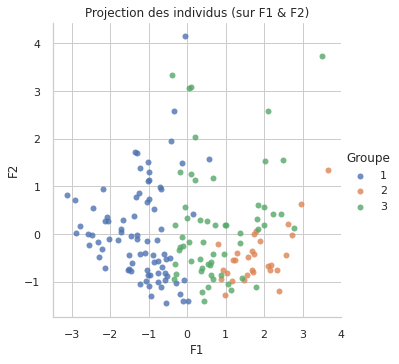

In [ ]:
# Projection des individus selon variable illustrative
sns.lmplot(x="F1", y = "F2", hue="Groupe", data=data_bon, fit_reg=False)
plt.title("Projection des individus (sur F1 & F2)")
plt.show()

Comme F1 est très corrélée aux variables disponibilité alimentaire, PIB/habitant et stabilité politique, alors il y a de grandes chances pour que ces individus aient aussi de grandes valeurs pour ces variables. Donc ceux du groupe 2 & 3. 

Pour F2 on peut dire que les indivis du groupe 1 sont tres correlée avec la croissance démographique & le TDI.

In [ ]:
data_bon_bon = cluster_cent.iloc[:,[0, 6, 7, 8]]
data_bon_bon.set_index('Groupe', inplace = True)
data_bon_bon

,F1,F2,F3
Groupe,,,
1,-1.211880,0.028290,0.127535
2,1.796081,-0.462035,0.484915
3,0.794413,0.191509,-0.420566


<Figure size 504x504 with 0 Axes>

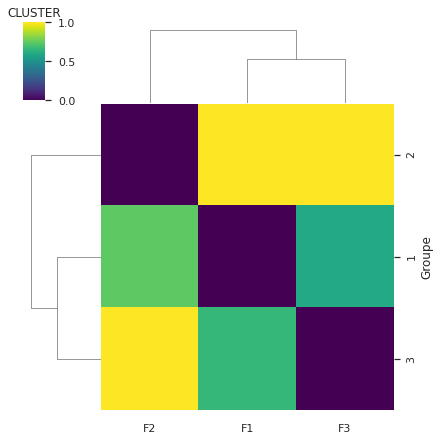

In [ ]:
#heatmap avec les croisements entre les clusters de pays et les différentes variables
plt.figure(figsize=(7, 7))
sns.clustermap(data_bon_bon, cmap = 'viridis',method = 'ward',metric = 'euclidean',standard_scale =1,figsize = (6, 6))
#sns.heatmap(df.corr(), annot=True, cmap='Greens')
plt.title('CLUSTER')
plt.savefig('Heatmap Cluster2.jpg')

**OBSERVATIONS**

Le groupe 2 présente les critères suivants :
*   Stabilité politique élevée
*   PIB/Habitant très important


Le groupe 3 présente les critères suivants :

*   TDI élévé
*   Croissance démographique relativement élevées

In [ ]:
data_final = data_bon.loc[data_bon['Groupe']==2]
data_final_ok = data_final.loc[:,['Zone','F2']]
data_final_ok.sort_values(by = ['F2'], ascending = [False]).head(3)

,Zone,F2
85,Luxembourg,1.351319
68,Irlande,0.632364
40,Danemark,0.214506


# <font color="red">**III. CONCLUSION**</font>

Nous avons mené une étude approfondie pour déterminer les pays qui présentaient les besoins les plus importants en matière de viande de volaille. Après avoir évalué les différents critères de sélection, nous avons conclu que le groupe 2 était celui qui correspondait le mieux à nos objectifs.

Parmi les pays de ce groupe, nous avons sélectionné ceux qui présentaient les caractéristiques les plus intéressantes pour notre entreprise. Nous avons donc choisi  **le Luxembourg**, **l'Irlande** et **le Danemark**, qui ont tous un fort potentiel de croissance en matière de consommation de viande de volaille.

Nous sommes convaincus que ces pays constitueront de bons marchés pour nos produits et nous espérons y développer de solides relations commerciales à long terme.





